# Notebook for testing cellpose for nucleus detection
Our main areas of interest are:
- Since a direct citoplasm detection fails, we've taken an approach that tries to do one at a time, mostly because the citoplasm isn't colored from the optical source.
-  If/what types of normalization would help us get better masks before applying cellpose
- What range of diameter gets better results
- If the normalization is better applyed after the cellpose algorithm
- Get the nucleus  remain within its bounds, because if it reaches the citoplasm, it ruins the citoplasm detection futher down the line.

## Installs


In [11]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2020 NVIDIA Corporation
Built on Mon_Oct_12_20:09:46_PDT_2020
Cuda compilation tools, release 11.1, V11.1.105
Build cuda_11.1.TC455_06.29190527_0
Wed Jan  5 20:35:34 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   72C    P0    75W / 149W |    603MiB / 11441MiB |      0%      Default |
|                               |            

In [12]:
!pip install cellpose

In [13]:
# import library
from google.colab import drive

#mount the drive
drive.mount('/content/drive')
# go to the url and get the password for the drive

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Imports

In [14]:
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
!pip install opencv-python-headless==4.1.2.30
import cv2
from matplotlib.colors import from_levels_and_colors
from skimage import data, img_as_float
from skimage import exposure
from skimage.filters import threshold_otsu

from skimage import color, morphology
from scipy import ndimage

     |████████████████████████████████| 21.8 MB 26.1 MB/s 


In [15]:
import numpy as np
import time, os, sys
from urllib.parse import urlparse
import skimage.io 
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
mpl.rcParams['figure.dpi'] = 300

from urllib.parse import urlparse

from cellpose import models, io, core, plot

use_GPU = core.use_gpu()
print('>>> GPU activated? %d'%use_GPU)

2022-01-05 20:35:42,730 [INFO] ** TORCH CUDA version installed and working. **
>>> GPU activated? 1


## Utils

In [16]:
#%% SECTION de definition et d'imports a lancer au debut
# Si vous êtes dans colab mettre colaboratory ET notebook a True
# si vous êtes en local dans un notebook mettez colbaoratory a False
#      et installez bokeh vous-même
# Si vous utilisez le script sur une machine local non pas dans un notebook 
# mettez les deux à False 
notebook=True
colaboratory=True
if notebook:
    from IPython.display import Audio
    if colaboratory:
        !pip install bokeh
    from bokeh.plotting import figure, output_file, show
    from bokeh.plotting import show as showbokeh
    from bokeh.io import output_notebook
    output_notebook()
    from bokeh.colors import Color as bcolor
    from bokeh.colors.rgb import RGB


import numpy as np

import matplotlib.pyplot as plt
import scipy 
from scipy.signal import lfilter
import scipy.io
import platform
import time

import tempfile
import os

def RGBtoYCrCb(im,ty='8bit'): 
    assert len(im.shape)==3 and im.shape[2]==3, 'image dans un mauvais format'
    if ty=='8bit':
        delta=128 #ce delta est simplement le milieu de la plage des valeurs 
                    # possibles. 
    out=np.empty(im.shape)
    Y=0.299*im[:,:,0]+0.587*im[:,:,1]+0.114*im[:,:,2]
    Cr=(im[:,:,0]-Y)*0.713+delta
    Cb=(im[:,:,2]-Y)*0.564+delta
    return (Y,Cr,Cb)



def YCrCbtoRGB(Y,Cr,Cb,ty='8bit'):
    delta=128
    out=np.empty([*Y.shape,3],dtype=np.float32)
    out[:,:,0]=Y+1.402*(Cr-delta)
    out[:,:,1]=Y-0.34414*(Cb-128)-0.71414*(Cr-128)
    out[:,:,2]=Y+1.772*(Cb-128)
    return out
    
import skimage.transform
if notebook:
  liste_couleurs_grises=[]
  for k in range(256):
    liste_couleurs_grises.append(RGB(k,k,k))
  def affiche_pour_colab(im,normalise=True,MINI=0.0, MAXI=255.0,titre=''): #special colab, ne pas regarder
    def normalise_image_pour_bokeh(X,normalise=True,MINI=0.0, MAXI=255.0,titre=''):
      Y=(X.copy())
      if len(Y.shape)==2: 
        Y=np.zeros((*Y.shape,3))
        for k in range(3):
          Y[:,:,k]=X.copy()
   
      if normalise:
        Y-=Y.min()
        Y/=Y.max()
        Y*=255
      else:
        Y-=MINI
        Y/=(MAXI-MINI)
        Y*=255

      Y=Y.astype(np.uint8)
      sortie=np.empty(Y.shape[:2],dtype=np.uint32)
      view=sortie.view(dtype=np.uint8).reshape((Y.shape[:2]+(4,)))
      for k in range(3):
        view[:,:,k]=Y[:,:,k]
      view[:,:,3]=255
      return sortie
    img=normalise_image_pour_bokeh(np.flipud(im),normalise=normalise,MINI=MINI,MAXI=MAXI)# np.flipud(np.fliplr(im)))
    p = figure(tooltips=[("x", "$x"), ("y", "$y"), ("value", "@image")],title=titre)
    p.x_range.range_padding = p.y_range.range_padding = 0

    # must give a vector of images
    p.image_rgba(image=[img],x=0,y=0, dw=im.shape[1], dh=im.shape[0])
    showbokeh(p)

  def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
      affiche_pour_colab(im,normalise=normalise,MINI=MINI, MAXI=MAXI,titre=titre) 
         # sous google colab beaucoup d''options disparaissent

else:
    def affiche(im,normalise=True,MINI=0.0, MAXI=255.0,titre='',printname=False):
        """ Cette fonction fait afficher l'image EN NIVEAUX DE GRIS 
        dans gimp. Si un gimp est deja ouvert il est utilise.
        Par defaut normalise=True. Et dans ce cas l'image est normalisee 
        entre 0 et 255 avant d'être sauvegardee.
        Si normalise=False MINI et MAXI seront mis a 0 et 255 dans l'image 
        resultat
        """
        imt=np.float32(im.copy())
        if platform.system()=='Darwin': #on est sous mac
            prephrase='open -a GIMP-2.10.app ' #certainement à adapter
            endphrase=' ' 
        else: #SINON ON SUPPOSE LINUX (si vous avez un windows je ne sais comment 
                                   #faire. Si vous savez dites-moi.)
            prephrase='gimp '
            endphrase= ' &'
    
        if normalise:
            m=imt.min()
            imt=imt-m
            M=imt.max()
            if M>0:
                imt=imt/M

        else:
            imt=(imt-MINI)/(MAXI-MINI)
            imt[imt<0]=0
            imt[imt>1]=1
    
        if titre!='':
            titre='_'+titre+'_'
        titre=titre.replace(' ','')
        nomfichier=tempfile.mktemp('TPIMA'+titre+'.png')
        commande=prephrase +nomfichier+endphrase
        skio.imsave(nomfichier,imt)
        os.system(commande)
        if printname:
            print(nomfichier)


if notebook:
    def plot(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif (len(argv)==1):
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: n'arriverait \
                pas hors de google colaboratory")
    
        p=figure()
        p.line(x,y)
        showbokeh(p)
    def stem(*argv):
        if len(argv)==2:
            x=argv[0]
            y=argv[1]
        elif len(argv)==1:
            x=np.arange(0,len(y))
            y=argv[0]
        else:
            raise Exception("Erreur dans les graphiques: \
                            n'arriverait pas hors de google colaboratory")

        p = figure()#title="simple line example", x_axis_label='x',
                    #y_axis_label='y')

        # add a line renderer with legend and line thickness
        p.segment(x,0,x, y, legend_label="Temp.", line_width=2)

        showbokeh(p)
    def show():
        return
else:
    plot=plt.plot
    stem=plt.stem
    show=plt.show # force l'affichage du graphique courant

def norm(X):
    return ((abs(X)**2).sum())**0.5
def read_image(fi):
    return np.float32(skio.imread(fi))

def normalization(img):
    pixels = np.asarray(img)
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # calculate global mean and standard deviation
    mean, std = pixels.mean(), pixels.std()
    # global standardization of pixels
    pixels = (pixels - mean) / np.max(std, 1e-8)
    return pixels


In [17]:
def clahe_otsu_erosion(img):  # apply threshold to green channel
  clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
  out = np.copy(img)
  green = clahe.apply(out[:,:,1])
  threshOtsu = threshold_otsu(green)
  green[green < threshOtsu] = 0

  #apply erosion to remove small points of green
  green =  skimage.morphology.erosion(green)
  out[:,:,1] = skimage.morphology.erosion(green)
  return out

def clahe_nuc(img):  
  # only equalization
  clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
  out = np.copy(img)
  out[:,:,1] = clahe.apply(out[:,:,1])
  return out

def cells_plot(X, y_pattern_dict, ctype, image_shape, collumn_size):
  n_classes = y_pattern_dict.shape[1]
  count = 0
  limit = collumn_size*(image_shape+2)
  out = np.zeros((2,limit))
  row = np.array([])
  n = 0
  for i, x in enumerate(X):
    c = np.argmax(y_pattern_dict[i])
    if c == ctype:
      if count == 0:
        row = np.c_[x, np.zeros((image_shape,2))]
      else:
        row = np.c_[row, np.c_[x, np.zeros((image_shape,2))]]
      count += 1
      if count == collumn_size:
        n += collumn_size
        out = np.r_[out, np.zeros((2,limit))]
        out = np.r_[out, row]
        row = np.array([])
        count = 0
  n += count
  if count != 0:
    for i in range(count, collumn_size):
        row = np.c_[row, np.c_[np.zeros((image_shape,image_shape+2))]]
    out = np.r_[out, np.zeros((2,limit))]
    out = np.r_[out, row]
  w, h = out.shape
  output = np.zeros((w, h, 3))
  output[:,:,1] = out
  return output, n
  

## Testing normalizations and segmentations of background

In [18]:
img_p = "/content/drive/MyDrive/Images/Patterns/pat_11/pat_11_1.jpg"
img = cv2.imread(img_p)
matplotlib.rcParams['font.size'] = 8
 

def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf

# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization

clahe = cv2.createCLAHE(clipLimit=10, tileGridSize=(8,8))
img_adapteq = np.copy(img)
img_adapteq[:,:,1] = clahe.apply(img[:,:,1])

# Display results
fig = plt.figure(figsize=(16, 10))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

Using a otsu threshold to potentialy remove background noise

In [19]:
# apply threshold to green channel
threshOtsu = threshold_otsu(img_adapteq[:,:,1])
img_otsu = np.copy(img_adapteq[:,:,1])
img_otsu[img_otsu < threshOtsu] = 0
img_out_otsu = np.copy(img_adapteq)
img_out_otsu[:,:,1] = img_otsu

#apply erosion to remove small points of green
img_otsu_cleaned =  skimage.morphology.erosion(img_otsu)
img_otsu_cleaned =  skimage.morphology.erosion(img_otsu_cleaned)
img_out_otsu_cleaned = np.copy(img_adapteq)
img_out_otsu_cleaned[:,:,1] = img_otsu_cleaned

# plot results
f, axarr = plt.subplots(1,3, figsize=(20,10))
axarr[0].imshow(img_adapteq)
axarr[0].set_title('Adaptive Equalization')
axarr[1].imshow(img_out_otsu)
axarr[1].set_title('Otsu')
axarr[2].imshow(img_out_otsu_cleaned)
axarr[2].set_title('Eroded Otsu')
plt.show()

Output hidden; open in https://colab.research.google.com to view.

## Apply cellpose

First we find the best diameter

In [20]:
model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
from cellpose import plot
# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [2, 0]
# channels = [1,1]
img_p = "/content/drive/MyDrive/Images/Patterns/pat_11/pat_11_1.jpg"
img = cv2.imread(img_p)
# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
img = clahe_nuc(img)
masks_out = []
for i in range(30, 90, 5):
    print(f'Diameter {i}')
    masks, flows, styles, diams = model.eval(img, diameter=i, channels=channels)
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Otsu test

Find if it is best to perform the normalization before of after cellpose,then find if the applying an otsu threshold betters the image.

In [21]:
model = models.Cellpose(gpu=use_GPU, model_type='nuclei')

# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [2, 0]
# channels = [1,1]

img_p = "/content/drive/MyDrive/Images/Patterns/pat_11/pat_11_1.jpg"
img = cv2.imread(img_p)
# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
img = clahe_otsu_erosion(img)
masks_out = []
for i in range(40, 100, 5):
    print(f'Diameter {i}')
    masks, flows, styles, diams = model.eval(img, diameter=i, channels=channels)
    fig = plt.figure(figsize=(12,5))
    plot.show_segmentation(fig, img, masks, flows[0], channels=channels)
    plt.tight_layout()
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

# Application to entire dataset

Now we test these parameters to the entire dataset, without otsu

In [22]:
model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
path = "/content/drive/MyDrive/Images/"
for pattern in glob.glob(path + '/*'):
  pattern_name = pattern[len(path)+1:]
  print(pattern_name)
  for image in glob.glob(pattern + '/*'):
    if image[-4:] == '.jpg':
      img = cv2.imread(image)
      img_clean = clahe_nuc(img)
      masks, flows, styles, diams = model.eval(img_clean, diameter=60, flow_threshold=None, channels=channels)
      from cellpose import plot
      fig = plt.figure(figsize=(12,5))
      plot.show_segmentation(fig, img_clean, masks, flows[0], channels=channels)
      plt.tight_layout()
      plt.show()
      break

Output hidden; open in https://colab.research.google.com to view.


Now we test these parameters to the entire dataset, with otsu

In [30]:
model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
path = "/content/drive/MyDrive/Images/Patterns"
for pattern in glob.glob(path + '/*'):
  pattern_name = pattern[len(path)+1:]
  print(pattern_name)
  for image in glob.glob(pattern + '/*'):
    if image[-4:] == '.jpg':
      img = cv2.imread(image)
      img_clean = clahe_otsu_erosion(img)
      masks, flows, styles, diams = model.eval(img_clean, diameter=60, channels=channels)
      from cellpose import plot
      fig = plt.figure(figsize=(12,5))
      plot.show_segmentation(fig, clahe_nuc(img), masks, flows[0], channels=channels)
      plt.tight_layout()
      plt.show()
      break

Output hidden; open in https://colab.research.google.com to view.

## Conclusions

- Best diameter: 60
- Normalization should be done before, with adaptive histogram equalization, with clip limit of 10
- Otsu and erosion don't help for all, so should be avoided

#Cellpose observations:



###pattern 15: 
	pretty decent job, really hard to find exact borders. - OK

###pattern 18: 
	Perfect - OK

###pattern 23:
	Was able to segment despite granular cytoplasm - OK

###pattern 16: 
	Perfect - ok

###pattern 11: 
	Perfect - OK
	
###pattern 22:
	Segmented same cell sometimes. Also had some difficulty distinguishing cells that are too close by

###pattern 12:
	Perfect - OK
###pattern 13:
	Perfect - OK
###pattern 10:
	Perfect - OK

###pattern 19:
	Perfect - OK
###pattern 8: 
	Perfect - OK
###Pattern 25:
	Perfect - OK
###pattern 9:
	Perfect - OK
###Pattern 7:
	Perfect - OK
###Final remarks:

Overall good segmentation despite not being perfect, applying a different cell size for every image would require an additional program for complete automation which wouldn’t necessarily be feasible. However, we recommend to use different colors for the nuclei and the cytoplasm, as cellpose would probably have an easier time distinguishing the two. 
	


# Cyto test
Here we can see a vast improvement in the detection of Cyto Fibreux's cells, the class that propagated the largest amount of missclassification in other cells.
For this and other classes of the type mentioned below, in the cytoplam detection, they do better, which is a good thing, because the difference in segmentation would indicate these bad classes.

2022-01-05 20:49:44,936 [INFO] ** TORCH CUDA version installed and working. **
2022-01-05 20:49:44,937 [INFO] >>>> using GPU
2022-01-05 20:49:45,064 [INFO] ~~~ FINDING MASKS ~~~
2022-01-05 20:49:47,567 [INFO] >>>> TOTAL TIME 2.50 sec


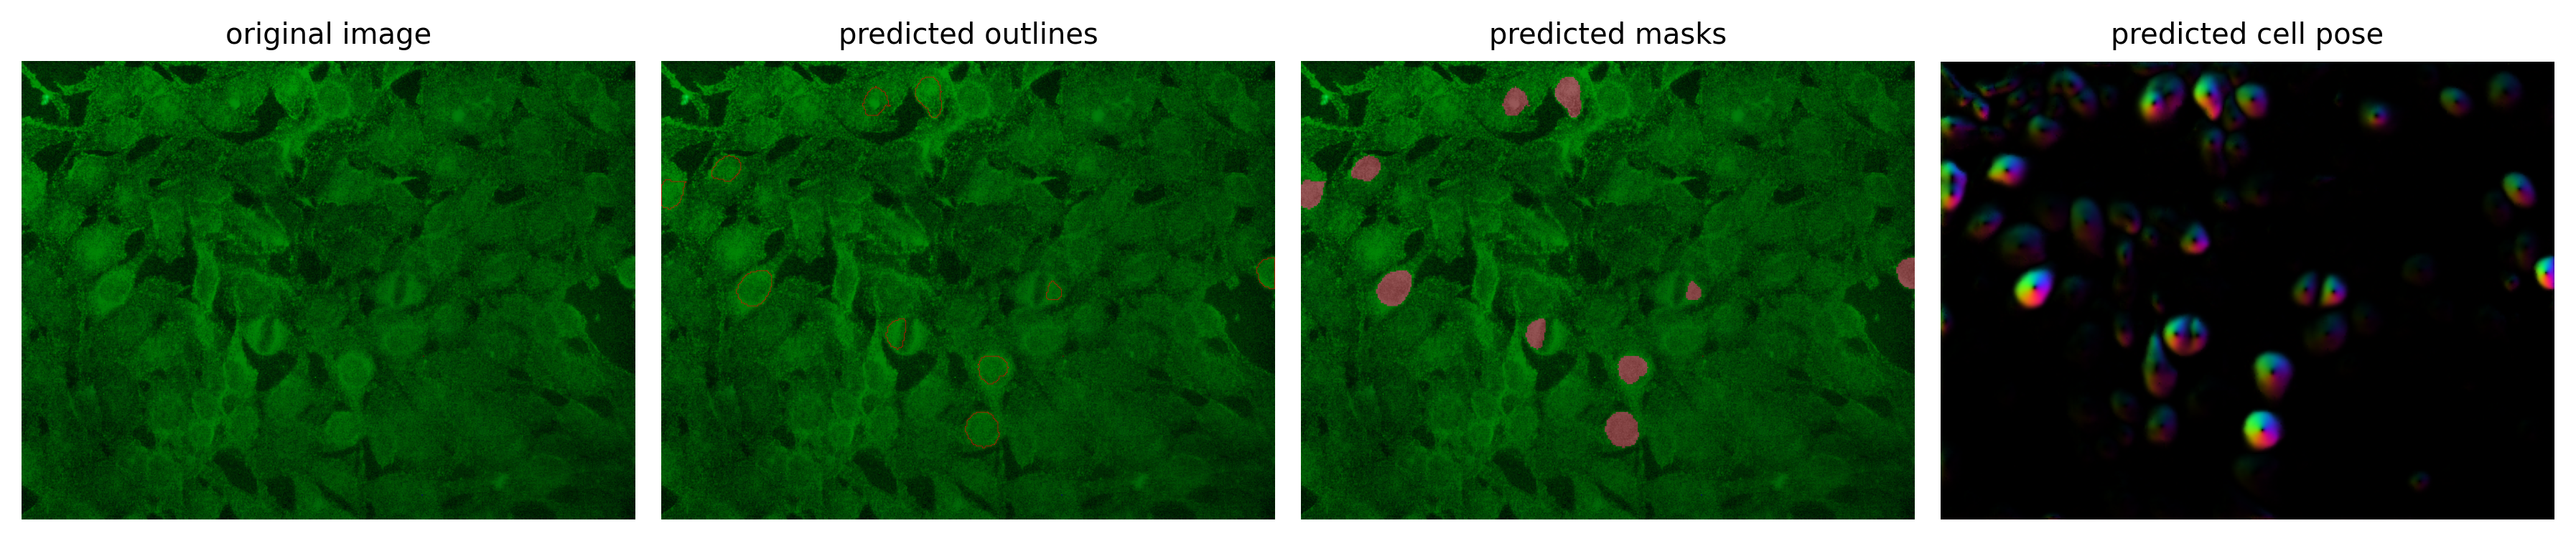

In [28]:
img = cv2.imread("/content/drive/MyDrive/Images/Images by class/Cyto Fibreux/Cyto Fibreux_1.jpg")
model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
# define CHANNELS to run segementation on
# grayscale=0, R=1, G=2, B=3
# channels = [cytoplasm, nucleus]
# if NUCLEUS channel does not exist, set the second channel to 0
# channels = [0,0]
# IF ALL YOUR IMAGES ARE THE SAME TYPE, you can give a list with 2 elements
# channels = [0,0] # IF YOU HAVE GRAYSCALE
# channels = [2,3] # IF YOU HAVE G=cytoplasm and B=nucleus
# channels = [2,1] # IF YOU HAVE G=cytoplasm and R=nucleus

# or if you have different types of channels in each image
channels = [2, 0]
# channels = [1,1]

# if diameter is set to None, the size of the cells is estimated on a per image basis
# you can set the average cell `diameter` in pixels yourself (recommended) 
# diameter can be a list or a single number for all images
img_clean = clahe_nuc(img)
masks, flows, styles, diams = model.eval(img_clean, diameter=60, channels=channels)
from cellpose import plot
fig = plt.figure(figsize=(12,5))
plot.show_segmentation(fig, img_clean, masks, flows[0], channels=channels)
plt.tight_layout()
plt.show()



In [26]:
model = models.Cellpose(gpu=use_GPU, model_type='nuclei')
path = "/content/drive/MyDrive/Images/Images by class"
for pattern in glob.glob(path + '/*'):
  pattern_name = pattern[len(path)+1:]
  print(pattern_name)
  for image in glob.glob(pattern + '/*'):
    if image[-4:] == '.jpg':
      img = cv2.imread(image)
      img_clean = clahe_nuc(img)
      masks, flows, styles, diams = model.eval(img_clean, diameter=60, flow_threshold=None, channels=channels)
      from cellpose import plot
      fig = plt.figure(figsize=(12,5))
      plot.show_segmentation(fig, img_clean, masks, flows[0], channels=channels)
      plt.tight_layout()
      plt.show()
      break

Output hidden; open in https://colab.research.google.com to view.

# Worst classes
- Cyto Fibreux (bad)
- Cyto filamenteux actine (medium-bad)
- Cyto filamenteux Vimentine (medium-bad)
- Cyto Ponctue Jo1 (bad)